In [1]:
import os
os.environ ['PYSPARK_PYTHON'] = 'python'

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, PolynomialExpansion
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [3]:
spark = SparkSession.builder.appName("crop").getOrCreate()

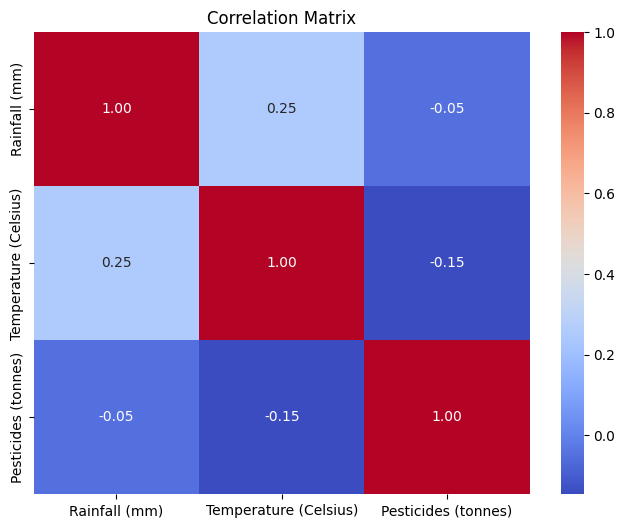

In [31]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a SparkSession
spark = SparkSession.builder.appName("CropYieldPrediction").getOrCreate()

# Read the CSV file into a Spark DataFrame
spark_df = spark.read.csv('C:/Users/GAURAV/Downloads/data.csv', header=True, inferSchema=True)

# Assemble the feature vector
vector_assembler = VectorAssembler(
    inputCols=["Rainfall (mm)", "Temperature (Celsius)", "Pesticides (tonnes)"],
    outputCol="feature_vector"
)

# Transform the DataFrame
crop_vector = vector_assembler.transform(spark_df)

# Select the feature vector column
feature_vector_df = crop_vector.select("feature_vector")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(feature_vector_df, "feature_vector").head()[0]

# Convert to a dense array for better readability
correlation_matrix_array = correlation_matrix.toArray()

# Get the names of the features for labeling
feature_names = ["Rainfall (mm)", "Temperature (Celsius)", "Pesticides (tonnes)"]

# Create a pandas DataFrame for the correlation matrix
correlation_df = pd.DataFrame(correlation_matrix_array, index=feature_names, columns=feature_names)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [4]:
spark_df = spark.read.csv('C:/Users/GAURAV/Downloads/data.csv',header=True , inferSchema=True)

In [33]:
spark_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Item: string (nullable = true)
 |-- Rainfall (mm): double (nullable = true)
 |-- Temperature (Celsius): double (nullable = true)
 |-- Pesticides (tonnes): integer (nullable = true)
 |-- Yield (hg/ha): integer (nullable = true)



In [17]:
spark_df.show()

+----+-------+--------------------+-------------+---------------------+-------------------+-------------+
|Year|Country|                Item|Rainfall (mm)|Temperature (Celsius)|Pesticides (tonnes)|Yield (hg/ha)|
+----+-------+--------------------+-------------+---------------------+-------------------+-------------+
|1990|Albania|              Barley|     812.2345|          12.05122083|                121|        10000|
|1990|Albania| Carrots and turnips|     812.2345|          12.05122083|                121|       150000|
|1990|Albania|Cauliflowers and ...|     812.2345|          12.05122083|                121|       171429|
|1990|Albania|              Garlic|     812.2345|          12.05122083|                121|        65000|
|1990|Albania|               Maize|     812.2345|          12.05122083|                121|        36613|
|1990|Albania|                Oats|     812.2345|          12.05122083|                121|         7500|
|1990|Albania|Onions, shallots,...|     812.23

In [18]:
spark_df=spark_df.dropna()
spark_df

DataFrame[Year: int, Country: string, Item: string, Rainfall (mm): double, Temperature (Celsius): double, Pesticides (tonnes): int, Yield (hg/ha): int]

In [37]:
main_spark_df = spark_df.dropna()
spark_df=spark_df.dropDuplicates()
spark_df.count()


25229

In [38]:


country_indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex")
item_indexer = StringIndexer(inputCol="Item", outputCol="ItemIndex")

country_encoder = OneHotEncoder(inputCol="CountryIndex", outputCol="CountryVec")
item_encoder = OneHotEncoder(inputCol="ItemIndex", outputCol="ItemVec")

vector_assembler = VectorAssembler(
    inputCols=["Year", "Rainfall (mm)", "Temperature (Celsius)", "Pesticides (tonnes)", "CountryVec", "ItemVec"],
    outputCol="feature_vector"
)

pipeline = Pipeline(stages=[country_indexer, item_indexer, country_encoder, item_encoder, vector_assembler])

pipeline_model = pipeline.fit(spark_df)
crop_vector = pipeline_model.transform(spark_df)

crop_vector = crop_vector.select(["feature_vector", "Yield (hg/ha)"])
crop_vector.show()

+--------------------+-------------+
|      feature_vector|Yield (hg/ha)|
+--------------------+-------------+
|(151,[0,1,2,3,121...|        26744|
|(151,[0,1,2,3,55,...|        88905|
|(151,[0,1,2,3,16,...|        59542|
|(151,[0,1,2,3,85,...|        28889|
|(151,[0,1,2,3,71,...|        14988|
|(151,[0,1,2,3,52,...|        96481|
|(151,[0,1,2,3,73,...|       336135|
|(151,[0,1,2,3,111...|       149400|
|(151,[0,1,2,3,124...|       184170|
|(151,[0,1,2,3,20,...|        22857|
|(151,[0,1,2,3,61,...|        28137|
|(151,[0,1,2,3,76,...|        29843|
|(151,[0,1,2,3,51,...|         8646|
|(151,[0,1,2,3,47,...|        38290|
|(151,[0,1,2,3,95,...|        20733|
|(151,[0,1,2,3,39,...|        12043|
|(151,[0,1,2,3,12,...|       108303|
|(151,[0,1,2,3,86,...|        61642|
|(151,[0,1,2,3,63,...|        15930|
|(151,[0,1,2,3,11,...|       138889|
+--------------------+-------------+
only showing top 20 rows



In [39]:
train_set1,test_set1=crop_vector.randomSplit([0.8,0.2])
#training the model
model1=LinearRegression(labelCol="Yield (hg/ha)", featuresCol="feature_vector")
model_trained1=model1.fit(train_set1)
#predicting
model_predict1=model_trained1.transform(test_set1)
model_predict1.show()


+--------------------+-------------+------------------+
|      feature_vector|Yield (hg/ha)|        prediction|
+--------------------+-------------+------------------+
|(151,[0,1,2,3,4],...|        11671| 40185.03110297769|
|(151,[0,1,2,3,4],...|         5069| 51908.60427056067|
|(151,[0,1,2,3,4],...|        10428|  63578.8732612445|
|(151,[0,1,2,3,4],...|         9121| 66057.17154743103|
|(151,[0,1,2,3,4],...|         7638| 67135.34157055756|
|(151,[0,1,2,3,4,1...|        49641| 63134.90359058604|
|(151,[0,1,2,3,4,1...|        51673| 96908.53627507435|
|(151,[0,1,2,3,4,1...|        58929|108991.44926719787|
|(151,[0,1,2,3,4,1...|       105654|193339.19347660802|
|(151,[0,1,2,3,4,1...|       149655|210309.15705729648|
|(151,[0,1,2,3,4,1...|       153168| 228149.4971080143|
|(151,[0,1,2,3,4,1...|       146283|231293.32141588768|
|(151,[0,1,2,3,4,1...|       144171|235647.78923950857|
|(151,[0,1,2,3,4,1...|       156686|238035.39088710072|
|(151,[0,1,2,3,4,1...|       176866| 244495.4913

In [40]:
evaluator = RegressionEvaluator(labelCol="Yield (hg/ha)", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(model_predict1)

evaluator = RegressionEvaluator(labelCol="Yield (hg/ha)", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(model_predict1)

# Displaying MAE and R2
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


Mean Absolute Error (MAE): 41019.41947387226
R-squared (R2): 0.671984492117149


In [45]:
country_indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex")
item_indexer = StringIndexer(inputCol="Item", outputCol="ItemIndex")

# OneHotEncoder for "CountryIndex" and "ItemIndex"
country_encoder = OneHotEncoder(inputCol="CountryIndex", outputCol="CountryVec")
item_encoder = OneHotEncoder(inputCol="ItemIndex", outputCol="ItemVec")

# VectorAssembler to combine all feature columns
vector_assembler = VectorAssembler(
    inputCols=["Year", "Rainfall (mm)", "Temperature (Celsius)", "Pesticides (tonnes)", "CountryVec", "ItemVec"],
    outputCol="features"
)

# PolynomialExpansion for Polynomial Regression
polynomial_expansion = PolynomialExpansion(degree=2, inputCol="features", outputCol="poly_features")

# Linear Regression Model
linear_regression = LinearRegression(featuresCol="features", labelCol="Yield (hg/ha)", predictionCol="prediction_lr")

# Random Forest Regressor
random_forest = RandomForestRegressor(featuresCol="features", labelCol="Yield (hg/ha)", predictionCol="prediction_rf")

# Pipeline for Polynomial Regression
poly_pipeline = Pipeline(stages=[country_indexer, item_indexer, country_encoder, item_encoder, vector_assembler, polynomial_expansion, linear_regression])

# Pipeline for Random Forest Regression
rf_pipeline = Pipeline(stages=[country_indexer, item_indexer, country_encoder, item_encoder, vector_assembler, random_forest])

# Fit the models
poly_model = poly_pipeline.fit(spark_df)
rf_model = rf_pipeline.fit(spark_df)

# Make predictions
poly_predictions = poly_model.transform(spark_df)
rf_predictions = rf_model.transform(spark_df)

# Evaluate models
metric_names = ["mae", "r2"]
for metric in metric_names:
    poly_evaluator = RegressionEvaluator(predictionCol="prediction_lr", labelCol="Yield (hg/ha)", metricName=metric)
    rf_evaluator = RegressionEvaluator(predictionCol="prediction_rf", labelCol="Yield (hg/ha)", metricName=metric)
    
    poly_metric_value = poly_evaluator.evaluate(poly_predictions)
    rf_metric_value = rf_evaluator.evaluate(rf_predictions)
    
    print(f"Polynomial Regression {metric}: {poly_metric_value}")
    print(f"Random Forest Regression {metric}: {rf_metric_value}")

# Show some predictions
poly_predictions.select("features", "poly_features", "Yield (hg/ha)", "prediction_lr").show()
rf_predictions.select("features", "Yield (hg/ha)", "prediction_rf").show()

Polynomial Regression mae: 41336.35145147108
Random Forest Regression mae: 48987.02194555971
Polynomial Regression r2: 0.6704966953711595
Random Forest Regression r2: 0.553717351583841
+--------------------+--------------------+-------------+-------------------+
|            features|       poly_features|Yield (hg/ha)|      prediction_lr|
+--------------------+--------------------+-------------+-------------------+
|(151,[0,1,2,3,121...|(11627,[0,1,2,3,4...|        26744| 7499.2197208385915|
|(151,[0,1,2,3,55,...|(11627,[0,1,2,3,4...|        88905|  98811.72413837165|
|(151,[0,1,2,3,16,...|(11627,[0,1,2,3,4...|        59542|  152697.1017260542|
|(151,[0,1,2,3,85,...|(11627,[0,1,2,3,4...|        28889| -5172.263342217077|
|(151,[0,1,2,3,71,...|(11627,[0,1,2,3,4...|        14988|-10678.957557661925|
|(151,[0,1,2,3,52,...|(11627,[0,1,2,3,4...|        96481|  79525.46662666695|
|(151,[0,1,2,3,73,...|(11627,[0,1,2,3,4...|       336135| 248676.68739809515|
|(151,[0,1,2,3,111...|(11627,[0,1,2

Text(0, 0.5, 'y_pred')

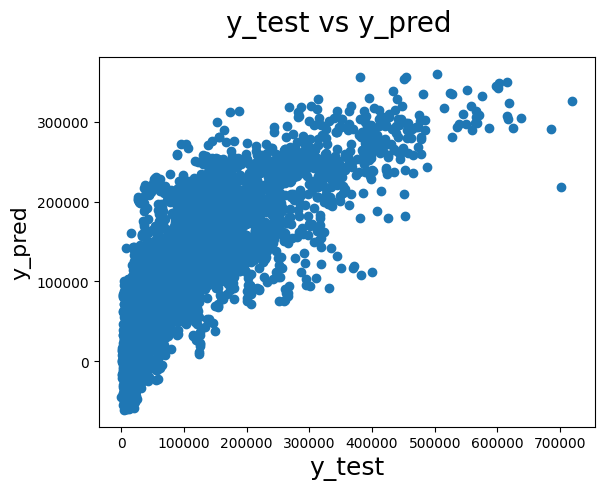

In [82]:
x = model_predict1.toPandas()['Yield (hg/ha)']
y = model_predict1.toPandas()['prediction']
fig = plt.figure()
plt.scatter(x,y)
fig.suptitle('y_test vs y_pred', fontsize=20) # Plot heading
plt.xlabel('y_test', fontsize=18) # X-label
plt.ylabel('y_pred', fontsize=16) # Y-label

In [44]:
data.to_csv('C:/Users/GAURAV/Downloads/data.csv', index=False)